In [2]:
# install kaggle package
!pip install -q kaggle

In [3]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"regitardia","key":"9bd07c33849b2ac74a42f8c7857ea2d3"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [12]:
!kaggle datasets download -d alessiocorrado99/animals10

 99% 577M/586M [00:14<00:00, 39.7MB/s]
100% 586M/586M [00:14<00:00, 42.9MB/s]


In [13]:
# unzip
!mkdir animals
!unzip -qq animals10.zip -d animals
!ls animals

mkdir: cannot create directory ‘animals’: File exists
animals10  raw-img  translate.py


In [14]:
!ls animals/animals10/raw-img/

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [15]:
import os

animals = os.path.join('/content/animals/animals10/raw-img/')

print(os.listdir(animals))

['squirrel', 'dog', 'horse', 'elephant', 'cow', 'sheep', 'cat', 'chicken', 'spider', 'butterfly']


In [16]:
import shutil

ignore_animals = ['squirrel', 'cat', 'butterfly', 'elephant', 'sheep', 'cow', ]

for x in ignore_animals:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [17]:
list_animals = os.listdir(animals)
print(list_animals)

['dog', 'horse', 'chicken', 'spider']


In [18]:
from PIL import Image
total = 0

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

dog: 4863
- (225, 300)
- (257, 300)
- (281, 300)
- (273, 300)
---------------
horse: 2623
- (300, 285)
- (300, 169)
- (300, 200)
- (300, 209)
---------------
chicken: 3098
- (300, 225)
- (225, 300)
- (300, 225)
- (300, 225)
---------------
spider: 4821
- (300, 228)
- (200, 300)
- (288, 300)
- (300, 145)
---------------

Total : 15405


<function matplotlib.pyplot.show>

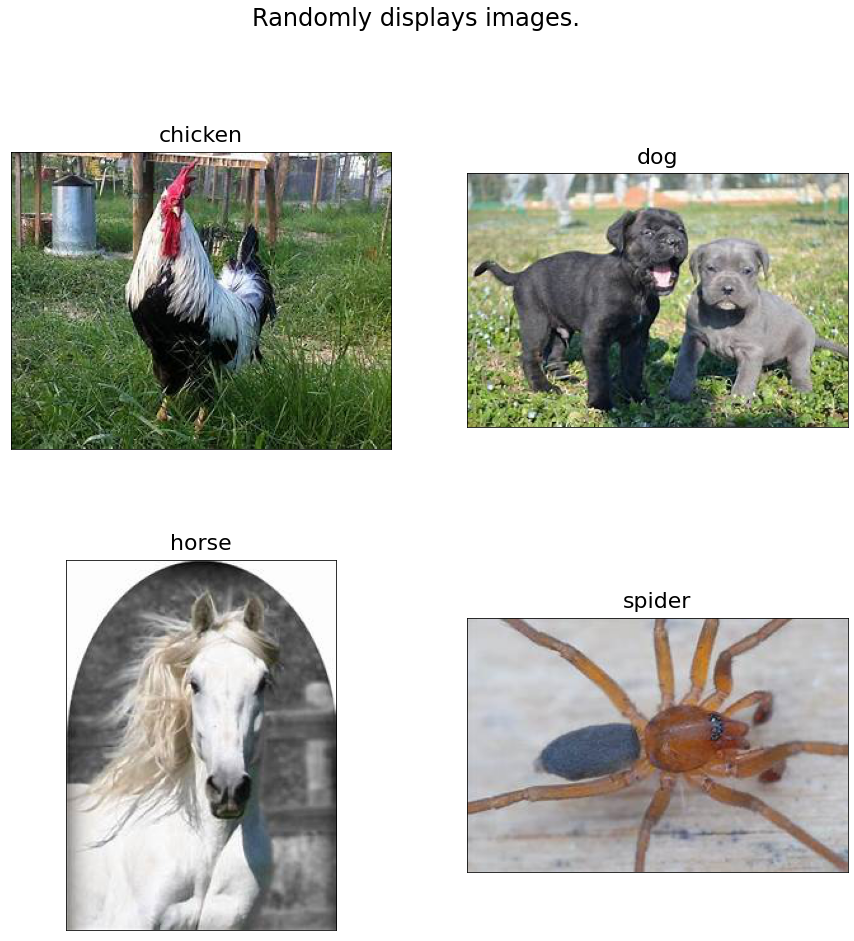

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle("Randomly displays images.", fontsize=24)
animals_sorted = sorted(list_animals)
animals_id = 0
for i in range(2):
  for j in range(2):
    try:
      animals_selected = animals_sorted[animals_id] 
      animals_id += 1
    except:
      break
    if animals_selected == '.TEMP':
        continue
    animals_selected_images = os.listdir(os.path.join(animals, animals_selected))
    animals_selected_random = np.random.choice(animals_selected_images)
    img = plt.imread(os.path.join(animals, animals_selected, animals_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(animals_selected, pad=10, fontsize=22)
    
plt.setp(ax, xticks=[],yticks=[])
plt.show

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   
)

In [21]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    animals, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 12326 images belonging to 4 classes.
Found 3079 images belonging to 4 classes.


In [22]:
import tensorflow as tf
# from tensorflow.keras import applications, optimizers

tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAccuracy above 92%, finish training!")
      self.model.stop_training = True

callbacks = myCallback()

In [25]:
history = model.fit(data_train, 
                    epochs = 64, 
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val, 
                    validation_steps = data_val.samples // batch_size,
                    verbose = 2,
                    callbacks = [callbacks])

Epoch 1/64
48/48 - 106s - loss: 1.0095 - accuracy: 0.5819 - val_loss: 0.9995 - val_accuracy: 0.5798
Epoch 2/64
48/48 - 105s - loss: 0.9307 - accuracy: 0.6225 - val_loss: 0.8972 - val_accuracy: 0.6354
Epoch 3/64
48/48 - 104s - loss: 0.8516 - accuracy: 0.6551 - val_loss: 0.8916 - val_accuracy: 0.6318
Epoch 4/64
48/48 - 102s - loss: 0.7958 - accuracy: 0.6864 - val_loss: 0.8107 - val_accuracy: 0.6807
Epoch 5/64
48/48 - 103s - loss: 0.7618 - accuracy: 0.6988 - val_loss: 0.7130 - val_accuracy: 0.7249
Epoch 6/64
48/48 - 103s - loss: 0.7185 - accuracy: 0.7219 - val_loss: 0.7471 - val_accuracy: 0.6956
Epoch 7/64
48/48 - 104s - loss: 0.7067 - accuracy: 0.7313 - val_loss: 0.6474 - val_accuracy: 0.7480
Epoch 8/64
48/48 - 103s - loss: 0.6436 - accuracy: 0.7568 - val_loss: 0.6162 - val_accuracy: 0.7679
Epoch 9/64
48/48 - 104s - loss: 0.6519 - accuracy: 0.7531 - val_loss: 0.6616 - val_accuracy: 0.7441
Epoch 10/64
48/48 - 104s - loss: 0.6208 - accuracy: 0.7670 - val_loss: 0.5828 - val_accuracy: 0.7790

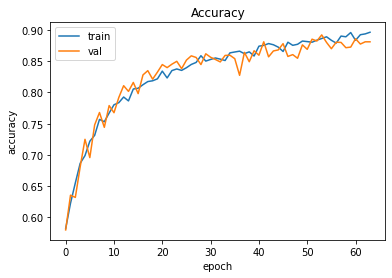

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

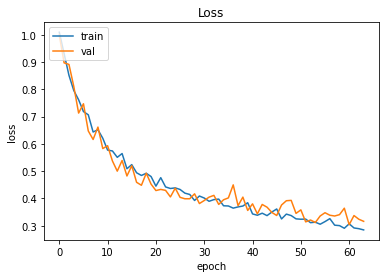

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpe1xrq99u/assets


In [29]:
!ls -la | grep 'model'

-rw-r--r-- 1 root root  13900684 Jul  2 15:49 model.tflite
